# Moview poster to category 

I wanted to explore the idea of classifing the category of the movie (romance, action, etc) based on the poster while also exploring [fast.ai](https://www.fast.ai/).
I used [this kaggle dataset](https://www.kaggle.com/neha1703/movie-genre-from-its-poster) which were obtained from [IMDB](https://www.imdb.com/).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
from fastai.vision import *
import download

np.random.seed(42)

## Pandas

Let's start off by exploring the dataset using pandas, and cleanup as needed

In [2]:
path = Path(os.path.expanduser('~'))/'data/kaggle_posters'
df = pd.read_csv(
    path/'MovieGenre.csv', encoding="ISO-8859-1", 
    dtype={'imdbId': str, 'Genre': str, 'Poster': str})

In [3]:
df = df.drop(columns=['Imdb Link', 'Title', 'IMDB Score'])
df.head()

,imdbId,Genre,Poster
0,114709,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


In [4]:
df.isna().sum()

imdbId      0
Genre     145
Poster    725
dtype: int64

In [5]:
df = df[~df['Genre'].isnull()]

In [6]:
if not (path/'posters').ls():
    await download.download_data({
            x['Poster']: path/'posters/{}'.format(x['imdbId']) for _, x in df.iterrows()})

In [7]:
verify_images(path/'posters', delete=True)

In [8]:
df = df[df['imdbId'].isin([x.stem for x in (path/'posters').ls()])]
df.shape

(39140, 3)

Check how many movies per-genre we have and remove the ones that have less than 1K examples

In [10]:
categories = set([g for s in df['Genre'].tolist() for g in s.split('|')])
l = []
for c in categories:
    l.append((c, df[df['Genre'].str.contains(c)].shape[0]))
    
['{} ({})'.format(*c) for c in sorted(l, key=lambda x: x[1])]

['Game-Show (1)',
 'Reality-TV (2)',
 'Talk-Show (6)',
 'Adult (9)',
 'News (80)',
 'Film-Noir (401)',
 'Sport (696)',
 'Musical (837)',
 'Western (843)',
 'Short (917)',
 'War (1158)',
 'History (1399)',
 'Animation (1699)',
 'Biography (1968)',
 'Fantasy (1994)',
 'Sci-Fi (2000)',
 'Music (2071)',
 'Family (2080)',
 'Mystery (2380)',
 'Documentary (3557)',
 'Adventure (3790)',
 'Horror (3972)',
 'Thriller (4787)',
 'Crime (5234)',
 'Action (5293)',
 'Romance (6168)',
 'Comedy (12518)',
 'Drama (19788)']

In [11]:
unwanted = [x[0] for x in l if x[1] < 1000]
cleaned = df
for u in unwanted:
    cleaned = cleaned[~cleaned['Genre'].str.contains(u)]

## Create the Databuch

In [15]:
src = (ImageList.from_df(cleaned, path/'posters', suffix='.jpg')
               .split_by_rand_pct()
               .label_from_df(cols=1, label_delim='|'))
src

LabelLists;

Train: LabelList (28314 items)
x: ImageList
Image (3, 268, 182),Image (3, 268, 182),Image (3, 268, 182),Image (3, 268, 182),Image (3, 268, 182)
y: MultiCategoryList
Animation;Adventure;Comedy,Action;Adventure;Family,Comedy;Romance,Comedy;Drama;Romance,Comedy;Family;Romance
Path: /home/javiber/data/kaggle_posters/posters;

Valid: LabelList (7078 items)
x: ImageList
Image (3, 268, 182),Image (3, 268, 182),Image (3, 268, 182),Image (3, 268, 182),Image (3, 268, 182)
y: MultiCategoryList
Drama,Animation;Action;Adventure,Animation;Adventure;Family,Action;Crime;Thriller,Drama
Path: /home/javiber/data/kaggle_posters/posters;

Test: None

I didn't use transformations because the posters will allways appear the same way in real life 

['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War']


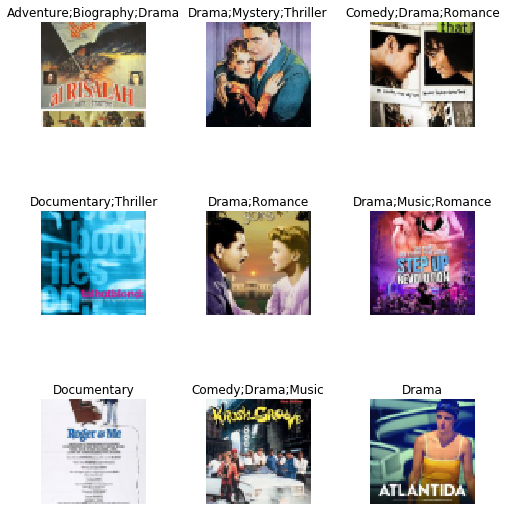

In [19]:
data = (src.transform([[], []], size=64)
               .databunch(bs=256).normalize(imagenet_stats))
print(data.classes)
data.show_batch(rows=3, figsize=(7,8))

## Training

In [29]:
learn = cnn_learner(data, models.resnet34, metrics=[partial(accuracy_thresh, thresh=0.2), fbeta])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


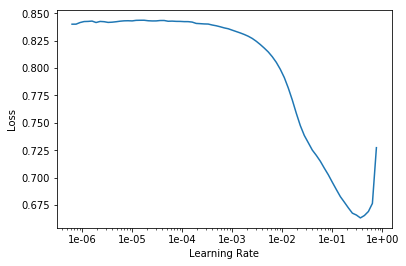

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
lr = 1e-2
learn.fit_one_cycle(6, slice(lr))
learn.save('stage-1')

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.423476,0.298967,0.837454,0.489876,00:17
1,0.311105,0.292171,0.838875,0.505344,00:17
2,0.293588,0.289234,0.837831,0.512581,00:17
3,0.286058,0.286875,0.846653,0.509500,00:18
4,0.279002,0.286589,0.844299,0.515697,00:18
5,0.274346,0.286335,0.842163,0.518832,00:17


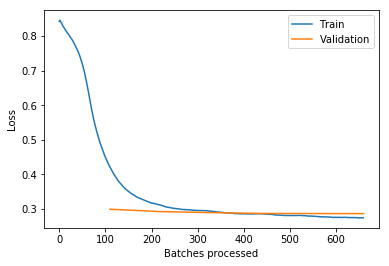

In [32]:
learn.recorder.plot_losses()

2924 misclassified samples over 7078 samples in the validation set.


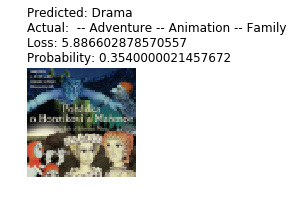

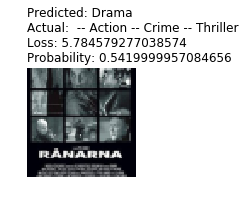

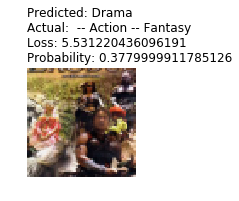

In [33]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_multi_top_losses(figsize=(2,2))

In [34]:
# helper to get the worst k classes according to fbeta score. It returns prec and rec for all of them
def worst_classes(self, k=5, thresh:float=0.2, beta:float=2, eps:float=1e-9, sigmoid:bool=True):
    # this is basically the code for fbeta
    beta2 = beta ** 2
    y_pred = (self.probs>thresh).float()
    
    if sigmoid: y_pred = y_pred.sigmoid()    
    
    y_true = self.y_true.float()
    TP = (y_pred*y_true).sum(dim=0)
    prec = TP/(y_pred.sum(dim=0)+eps)
    rec = TP/(y_true.sum(dim=0)+eps)
    fbeta = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    
    sorted_res, sorted_idx = fbeta.sort()
    total_true = y_true.sum(0)
    return [(self.data.classes[i], total_true[i], fbeta[i], prec[i], rec[i]) for i in sorted_idx[:k]]

In [36]:
worst_classes(interp, k=data.c)

[('Music', tensor(236.), tensor(0.1316), tensor(0.0333), tensor(0.5000)),
 ('War', tensor(238.), tensor(0.1327), tensor(0.0337), tensor(0.5010)),
 ('History', tensor(266.), tensor(0.1445), tensor(0.0376), tensor(0.5000)),
 ('Biography', tensor(335.), tensor(0.1716), tensor(0.0473), tensor(0.5000)),
 ('Animation', tensor(277.), tensor(0.1742), tensor(0.0456), tensor(0.5918)),
 ('Fantasy', tensor(403.), tensor(0.1970), tensor(0.0573), tensor(0.5046)),
 ('Family', tensor(377.), tensor(0.2019), tensor(0.0573), tensor(0.5478)),
 ('Sci-Fi', tensor(396.), tensor(0.2024), tensor(0.0584), tensor(0.5274)),
 ('Mystery', tensor(440.), tensor(0.2125), tensor(0.0634), tensor(0.5147)),
 ('Documentary', tensor(631.), tensor(0.2825), tensor(0.0953), tensor(0.5549)),
 ('Adventure', tensor(698.), tensor(0.3095), tensor(0.1082), tensor(0.5785)),
 ('Horror', tensor(798.), tensor(0.3464), tensor(0.1272), tensor(0.6089)),
 ('Thriller', tensor(931.), tensor(0.3659), tensor(0.1433), tensor(0.5983)),
 ('Crime',

We can see a strong correlation between how well we did on a category and how many examples of it we had

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


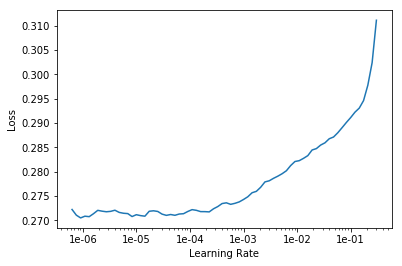

In [38]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(2, slice(1e-5, lr/5))
learn.save('stage-2')

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.278368,0.283632,0.845264,0.521492,00:17
1,0.245952,0.287834,0.843788,0.523311,00:17


In [40]:
interp = ClassificationInterpretation.from_learner(learn)
worst_classes(interp, k=data.c)

[('Music', tensor(236.), tensor(0.1319), tensor(0.0334), tensor(0.5010)),
 ('War', tensor(238.), tensor(0.1343), tensor(0.0341), tensor(0.5078)),
 ('History', tensor(266.), tensor(0.1444), tensor(0.0375), tensor(0.5000)),
 ('Biography', tensor(335.), tensor(0.1719), tensor(0.0474), tensor(0.5014)),
 ('Animation', tensor(277.), tensor(0.1774), tensor(0.0464), tensor(0.6026)),
 ('Fantasy', tensor(403.), tensor(0.1976), tensor(0.0574), tensor(0.5075)),
 ('Family', tensor(377.), tensor(0.2025), tensor(0.0574), tensor(0.5496)),
 ('Sci-Fi', tensor(396.), tensor(0.2075), tensor(0.0597), tensor(0.5443)),
 ('Mystery', tensor(440.), tensor(0.2176), tensor(0.0647), tensor(0.5315)),
 ('Documentary', tensor(631.), tensor(0.2862), tensor(0.0962), tensor(0.5652)),
 ('Adventure', tensor(698.), tensor(0.3140), tensor(0.1095), tensor(0.5887)),
 ('Horror', tensor(798.), tensor(0.3504), tensor(0.1286), tensor(0.6161)),
 ('Thriller', tensor(931.), tensor(0.3679), tensor(0.1437), tensor(0.6032)),
 ('Crime',

Use bigger images

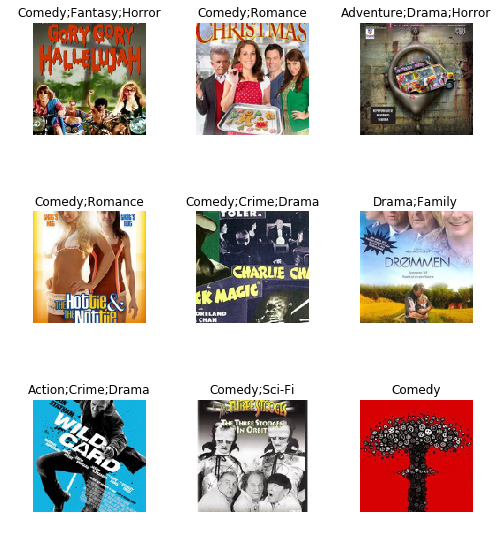

In [41]:
data = (src.transform([[], []], size=128)
               .databunch(bs=128).normalize(imagenet_stats))
data.show_batch(rows=3, figsize=(7,8))
learn.data=data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


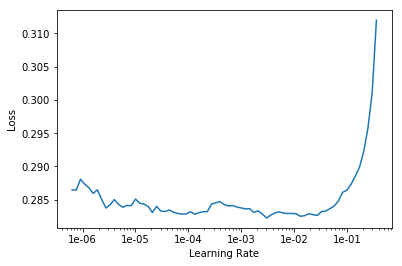

In [42]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [43]:
lr = 1e-3
learn.fit_one_cycle(4, slice(lr))
learn.save('stage-1-128')

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.279337,0.278187,0.847627,0.541002,00:22
1,0.274569,0.275593,0.849871,0.543622,00:21
2,0.270166,0.274629,0.847069,0.547301,00:21
3,0.267205,0.274485,0.849243,0.546139,00:21


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


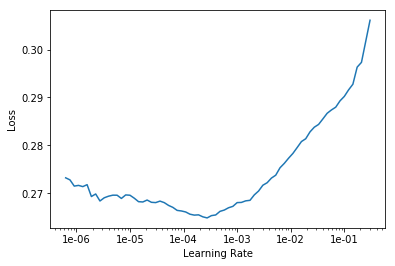

In [44]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [45]:
learn.fit_one_cycle(2, slice(1e-5, lr/5))
learn.save('stage-2-128')

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.265238,0.270490,0.853592,0.554690,00:28
1,0.245693,0.270279,0.852462,0.557264,00:28


256 image size

In [46]:
data = (src.transform([[], []], size=256)
               .databunch(bs=64).normalize(imagenet_stats))
learn.data=data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


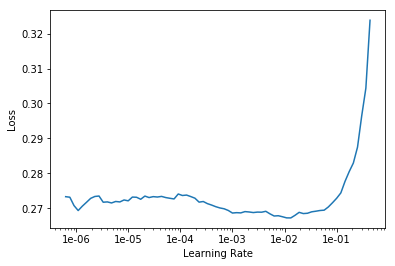

In [47]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [48]:
lr = 1e-3
learn.fit_one_cycle(4, slice(lr))
learn.save('stage-1-256')

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.266617,0.265868,0.855523,0.569435,01:09
1,0.262700,0.263338,0.858199,0.573930,01:09
2,0.259054,0.262288,0.857720,0.576486,01:09
3,0.255601,0.262012,0.856794,0.578781,01:09


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


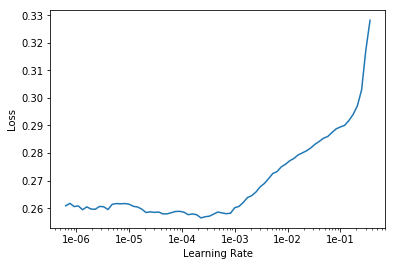

In [49]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [50]:
learn.fit_one_cycle(2, slice(1e-5, lr/5))
learn.save('stage-2-256')

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.252917,0.257982,0.860138,0.582835,01:31
1,0.232694,0.257253,0.859580,0.587567,01:31


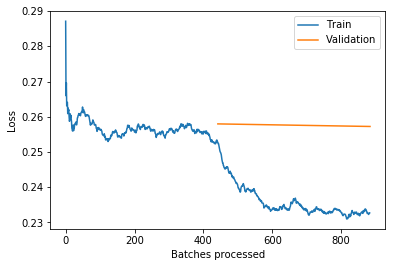

In [51]:
learn.recorder.plot_losses()

In [52]:
interp = ClassificationInterpretation.from_learner(learn)

In [61]:
t2 = worst_classes(interp, k=data.c, thresh=0.2)
t5 = worst_classes(interp, k=data.c, thresh=0.5)
t9 = worst_classes(interp, k=data.c, thresh=0.9)
for i in range(len(t2)):
    print('{}: {} | {} | {}'.format(t2[i][0], t2[i][2], t5[i][2], t9[i][2]))

Music: 0.13270533084869385 | 0.13160830736160278 | 0.13160830736160278
War: 0.13847039639949799 | 0.13248038291931152 | 0.1324872076511383
History: 0.1471947282552719 | 0.14447100460529327 | 0.14447100460529327
Biography: 0.17308203876018524 | 0.17165401577949524 | 0.16822391748428345
Animation: 0.19616365432739258 | 0.18664976954460144 | 0.17165401577949524
Fantasy: 0.2018337845802307 | 0.19601529836654663 | 0.186736062169075
Family: 0.2157825380563736 | 0.19646093249320984 | 0.19324615597724915
Mystery: 0.21640238165855408 | 0.19766992330551147 | 0.19559308886528015
Sci-Fi: 0.21841827034950256 | 0.20779529213905334 | 0.20758631825447083
Documentary: 0.3031812608242035 | 0.2707449197769165 | 0.260545939207077
Adventure: 0.32546427845954895 | 0.2937181890010834 | 0.27562785148620605
Horror: 0.36980512738227844 | 0.33158257603645325 | 0.3042256832122803
Thriller: 0.378692626953125 | 0.3379889130592346 | 0.32045987248420715
Crime: 0.38380587100982666 | 0.34128713607788086 | 0.32988661527

In [62]:
worst_classes(interp, k=data.c, thresh=0.2)

[('Music', tensor(236.), tensor(0.1327), tensor(0.0336), tensor(0.5049)),
 ('War', tensor(238.), tensor(0.1385), tensor(0.0351), tensor(0.5252)),
 ('History', tensor(266.), tensor(0.1472), tensor(0.0383), tensor(0.5104)),
 ('Biography', tensor(335.), tensor(0.1731), tensor(0.0477), tensor(0.5048)),
 ('Animation', tensor(277.), tensor(0.1962), tensor(0.0513), tensor(0.6677)),
 ('Fantasy', tensor(403.), tensor(0.2018), tensor(0.0586), tensor(0.5195)),
 ('Family', tensor(377.), tensor(0.2158), tensor(0.0611), tensor(0.5870)),
 ('Mystery', tensor(440.), tensor(0.2164), tensor(0.0645), tensor(0.5263)),
 ('Sci-Fi', tensor(396.), tensor(0.2184), tensor(0.0628), tensor(0.5747)),
 ('Documentary', tensor(631.), tensor(0.3032), tensor(0.1014), tensor(0.6029)),
 ('Adventure', tensor(698.), tensor(0.3255), tensor(0.1134), tensor(0.6109)),
 ('Horror', tensor(798.), tensor(0.3698), tensor(0.1359), tensor(0.6491)),
 ('Thriller', tensor(931.), tensor(0.3787), tensor(0.1481), tensor(0.6201)),
 ('Crime',

In [64]:
learn.export()